In [2]:
#AudioCLIP

import glob

import librosa
import librosa.display

import simplejpeg

import torchvision as tv

import matplotlib.pyplot as plt

from PIL import Image
from IPython.display import Audio, display

sys.path.append('AudioCLIP')

from model import AudioCLIP
from utils.transforms import ToTensor1D

MODEL_FILENAME = 'AudioCLIP-Full-Training.pt'
# derived from ESResNeXt
SAMPLE_RATE = 44100
# derived from CLIP
IMAGE_SIZE = 224
IMAGE_MEAN = 0.48145466, 0.4578275, 0.40821073
IMAGE_STD = 0.26862954, 0.26130258, 0.27577711

In [3]:
audio_transforms = ToTensor1D()

image_transforms = tv.transforms.Compose([
    tv.transforms.ToTensor(),
    tv.transforms.Resize(IMAGE_SIZE, interpolation=Image.BICUBIC),
    tv.transforms.CenterCrop(IMAGE_SIZE),
    tv.transforms.Normalize(IMAGE_MEAN, IMAGE_STD)
])

/data/scratch/ngop/.envs/audio-clip/lib/python3.7/site-packages/torchvision/transforms/transforms.py:281: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


In [8]:
def read_data(img_dir, audio_dir):
    img_dir += "*.jpg"
    audio_dir += "*.wav"
    
    paths_to_audio = glob.glob(audio_dir)

    audio = list()
    for path_to_audio in paths_to_audio:
        track, _ = librosa.load(path_to_audio, sr=SAMPLE_RATE, dtype=np.float32)

        # compute spectrograms using trained audio-head (fbsp-layer of ESResNeXt)
        # thus, the actual time-frequency representation will be visualized
        spec = aclp.audio.spectrogram(torch.from_numpy(track.reshape(1, 1, -1)))
        spec = np.ascontiguousarray(spec.numpy()).view(np.complex64)
        pow_spec = 10 * np.log10(np.abs(spec) ** 2 + 1e-18).squeeze()

        audio.append((track, pow_spec))
    
    paths_to_images = glob.glob(img_dir)

    images = list()
    for path_to_image in paths_to_images:
        with open(path_to_image, 'rb') as jpg:
            image = simplejpeg.decode_jpeg(jpg.read())
            images.append(image)
    return images, audio

In [5]:
def embedding(text = None, images = None, audio = None):
    text_features = []
    image_features = []
    audio_features = []
    
    # AudioCLIP handles raw audio on input, so the input shape is [batch x channels x duration]
    audio = torch.stack([audio_transforms(track.reshape(1, -1)) for track, _ in audio])
    # standard channel-first shape [batch x channels x height x width]
    images = torch.stack([image_transforms(image) for image in images])
    # textual input is processed internally, so no need to transform it beforehand
    text = [[label] for label in text]
    
    if audio != None: 
        ((audio_features, _, _), _), _ = aclp(audio=audio)
        audio_features = audio_features / torch.linalg.norm(audio_features, dim=-1, keepdim=True)
    if images != None:
        ((_, image_features, _), _), _ = aclp(image=images)
        image_features = image_features / torch.linalg.norm(image_features, dim=-1, keepdim=True)
    if text != None:
        ((_, _, text_features), _), _ = aclp(text=text)
        text_features = text_features / torch.linalg.norm(text_features, dim=-1, keepdim=True)
    return text_features, image_features, audio_features

In [6]:
def sim(text_features = None, image_features = None, audio_features = None):
    scale_audio_image = torch.clamp(aclp.logit_scale_ai.exp(), min=1.0, max=100.0)
    scale_audio_text = torch.clamp(aclp.logit_scale_at.exp(), min=1.0, max=100.0)
    scale_image_text = torch.clamp(aclp.logit_scale.exp(), min=1.0, max=100.0)
    
    logits_audio_image = []
    logits_audio_text = []
    logits_image_text = []
    
    if(audio_features != None and image_features != None):
        logits_audio_image = scale_audio_image * audio_features @ image_features.T
    
    if(audio_features != None and text_features != None):
        logits_audio_text = scale_audio_text * audio_features @ text_features.T
    
    if(image_features != None and text_features != None):
        logits_image_text = scale_image_text * image_features @ text_features.T
        
    return logits_audio_image, logits_audio_text, logits_image_text

In [7]:
def show_audio(audio):
    fig, axes = plt.subplots(2, len(audio), figsize=(20, 5), dpi=100)

    for idx in range(len(audio)):
        track, pow_spec = audio[idx]

        # draw the waveform
        librosa.display.waveplot(track, sr=SAMPLE_RATE, ax=axes[0, idx], color='k')
        # show the corresponding power spectrogram
        axes[1, idx].imshow(pow_spec, origin='lower', aspect='auto', cmap='gray', vmin=-180.0, vmax=20.0)

        # modify legend
        axes[0, idx].set_title(os.path.basename(paths_to_audio[idx]))
        axes[0, idx].set_xlabel('')
        axes[0, idx].set_xticklabels([])
        axes[0, idx].grid(True)
        axes[0, idx].set_ylim(bottom=-1, top=1)

        axes[1, idx].set_xlabel('Time (s)')
        axes[1, idx].set_xticks(np.linspace(0, pow_spec.shape[1], len(axes[0, idx].get_xticks())))
        axes[1, idx].set_xticklabels([f'{tick:.1f}' if tick == int(tick) else '' for tick in axes[0, idx].get_xticks()])
        axes[1, idx].set_yticks(np.linspace(0, pow_spec.shape[0] - 1, 5))

    axes[0, 0].set_ylabel('Amplitude')
    axes[1, 0].set_ylabel('Filter ID')

    plt.show()
    plt.close(fig)

    for idx, path in enumerate(paths_to_audio):
        print(os.path.basename(path))
        display(Audio(audio[idx][0], rate=SAMPLE_RATE, embed=True))

In [21]:
print(paths_to_audio)

['asset/sound/cat/']


In [12]:
torch.set_grad_enabled(False)

In [10]:
aclp = AudioCLIP(pretrained=f'AudioCLIP/assets/{MODEL_FILENAME}')

# Visualize Cat Sound

In [66]:
#paths_to_audio = glob.glob("AudioCLIP/demo/audio/*.wav")

#_, audio = read_data("AudioCLIP/demo/images/", "AudioCLIP/demo/audio/")

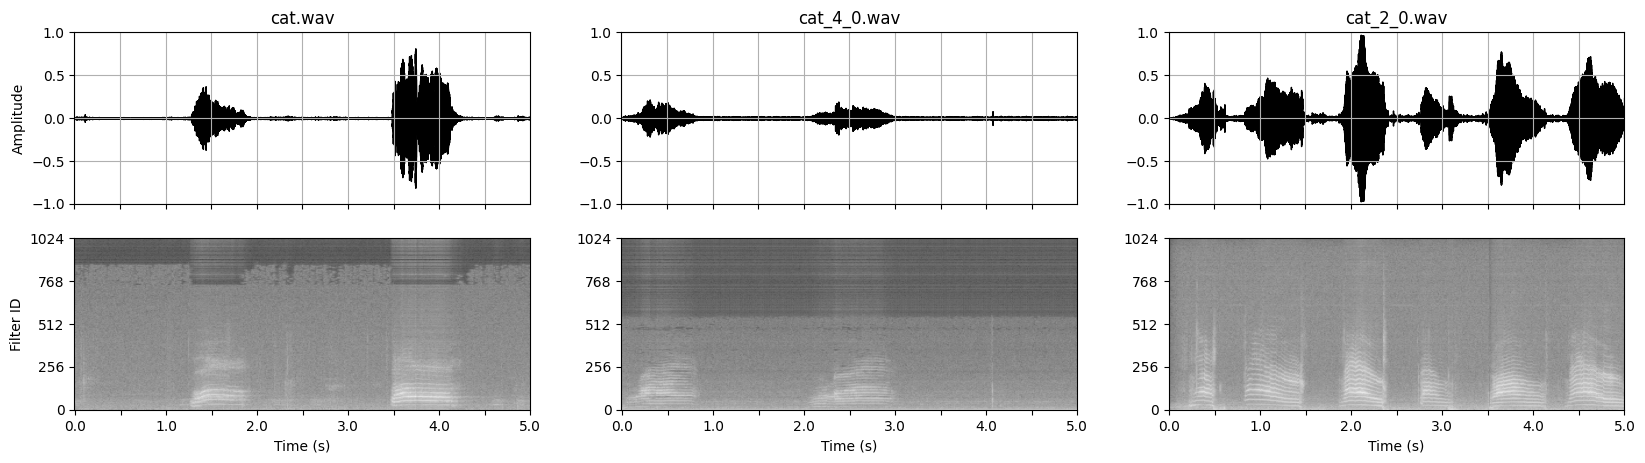

cat.wav


cat_4_0.wav


cat_2_0.wav


In [79]:
show_audio(audio)

In [75]:
label = ['dog', 'cat', 'human', 'wave', 'glitch', 'thunder', 'alarm clock', 'car', 'coughing']

In [76]:
text_rep, image_rep, audio_rep = embedding(label, _, audio)

In [77]:
_, audio_text_sim, _ = sim(text_rep, None, audio_rep)

In [78]:
print('\t\tFilename, Audio\t\t\tTextual Label (Confidence)', end='\n\n')

# calculate model confidence
confidence = audio_text_sim.softmax(dim=1)
for audio_idx in range(len(paths_to_audio)):
    # acquire Top-3 most similar results
    conf_values, ids = confidence[audio_idx].topk(3)

    # format output strings
    query = f'{os.path.basename(paths_to_audio[audio_idx]):>30s} ->\t\t'
    results = ', '.join([f'{label[i]:>15s} ({v:06.2%})' for v, i in zip(conf_values, ids)])

    print(query + results)

		Filename, Audio			Textual Label (Confidence)

                       cat.wav ->		            cat (80.59%),            wave (10.93%),             dog (03.61%)
                   cat_4_0.wav ->		         glitch (31.12%),            wave (20.48%),             car (16.71%)
                   cat_2_0.wav ->		           wave (64.03%),             dog (13.78%),           human (05.49%)
